In [1]:
import torch
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from sklearn.metrics import accuracy_score

In [ ]:
MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"
ACCESS_TOKEN = "<token>"

In [3]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [4]:
def count_layers(model):
    """Count the number of layers in a model"""
    return len([name for name, param in model.named_parameters() if 'layer' in name])

def count_non_zero_params(model):
    """Count non-zero parameters in a model"""
    total_params = 0
    non_zero_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            non_zero_params += (param.data != 0).sum().item()
    
    return non_zero_params, total_params

def estimate_flops(model, seq_length=128):
    """Estimate FLOPs for a transformer model"""
    config = model.config
    hidden_size = getattr(config, 'hidden_size', 768)
    num_layers = getattr(config, 'num_hidden_layers', 12)
    num_attention_heads = getattr(config, 'num_attention_heads', 12)
    
    # Estimate FLOPs for one forward pass
    # This is a simplified estimation
    flops_per_token = 0
    
    # Self-attention operations
    flops_per_token += 4 * num_layers * hidden_size * hidden_size  # Query, key, value, output projections
    flops_per_token += 2 * num_layers * seq_length * hidden_size  # QK attention
    
    # FFN operations
    ffn_dim = getattr(config, 'intermediate_size', 4 * hidden_size)
    flops_per_token += 2 * num_layers * hidden_size * ffn_dim  # Two linear layers in FFN
    
    # Multiply by sequence length
    total_flops = flops_per_token * seq_length
    
    # Adjust for sparsity
    non_zero_params, total_params = count_non_zero_params(model)
    sparsity_ratio = non_zero_params / total_params if total_params > 0 else 0
    
    # Adjust FLOPs based on sparsity (this is a simplification)
    adjusted_flops = total_flops * sparsity_ratio
    
    return adjusted_flops, total_flops

def disable_low_weight_neurons(model, threshold_percentage=0.5):
    """
    Disable low-weight neurons in a model and report metrics before and after.
    
    Args:
        model: The PyTorch model
        threshold_percentage: The percentage threshold for pruning (0-100)
        
    Returns:
        tuple: (modified model, metrics dictionary)
    """
    # Get original metrics
    original_number_of_layers = count_layers(model)
    original_non_zero_params, original_total_params = count_non_zero_params(model)
    original_flops_estimate, original_total_flops = estimate_flops(model)
    
    print(f"Original metrics:")
    print(f"Number of layers: {original_number_of_layers}")
    print(f"Parameters: {original_non_zero_params:,}/{original_total_params:,} ({original_non_zero_params/original_total_params*100:.2f}%)")
    print(f"Estimated FLOPs: {original_flops_estimate:,.0f}")
    
    # Disable low-weight neurons
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.shape) > 1:
            max_weight = torch.abs(param.data).max().item()
            threshold = max_weight * (threshold_percentage / 100)
            
            mask = torch.abs(param.data) >= threshold
            param.data[~mask] = 0.0
    
    # Get metrics after pruning
    pruned_non_zero_params, pruned_total_params = count_non_zero_params(model)
    pruned_flops_estimate, pruned_total_flops = estimate_flops(model)
    
    print(f"\nAfter pruning (threshold: {threshold_percentage}%):")
    print(f"Parameters: {pruned_non_zero_params:,}/{pruned_total_params:,} ({pruned_non_zero_params/pruned_total_params*100:.2f}%)")
    print(f"Estimated FLOPs: {pruned_flops_estimate:,.0f}")
    print(f"Reduction in parameters: {(1 - pruned_non_zero_params/original_non_zero_params)*100:.2f}%")
    print(f"Reduction in FLOPs: {(1 - pruned_flops_estimate/original_flops_estimate)*100:.2f}%")
    
    return model, {
        "original": {
            "total_layers": original_number_of_layers,
            "non_zero_params": original_non_zero_params,
            "total_params": original_total_params,
            "flops_estimate": original_flops_estimate
        },
        "after_pruning": {
            "non_zero_params": pruned_non_zero_params,
            "total_params": pruned_total_params,
            "flops_estimate": pruned_flops_estimate,
            "params_reduction_percentage": (1 - pruned_non_zero_params/original_non_zero_params)*100,
            "flops_reduction_percentage": (1 - pruned_flops_estimate/original_flops_estimate)*100
        }
    }

In [10]:
def evaluate_model(model, tokenizer, validation_df):
    """Evaluate model accuracy on the validation set with probability grouping"""
    predictions = []
    true_labels = []
    
    for index, row in validation_df.iterrows():
        text = row['text']
        true_label = row['label']
        
        text = preprocess(text)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probs = softmax(scores)
        
        # Group probabilities:
        # Sum probs of classes 0,1 (Very Negative + Negative) for negative sentiment
        # Use prob of class 2 (Neutral) for neutral sentiment
        # Sum probs of classes 3,4 (Positive + Very Positive) for positive sentiment
        neg_prob = probs[0] + probs[1]
        neutral_prob = probs[2]
        pos_prob = probs[3] + probs[4]
        
        # Get the highest probability group
        sentiment_probs = [neg_prob, neutral_prob, pos_prob]
        mapped_prediction = np.argmax(sentiment_probs)
        
        predictions.append(mapped_prediction)
        true_labels.append(true_label)

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

def evaluate_thresholds(model_name, validation_path, thresholds, tokenizer, original_model):
    """
    Evaluate model performance across different pruning thresholds
    
    Args:
        model_name: Name or path of the HuggingFace model
        validation_path: Path to the validation CSV
        thresholds: List of threshold percentages to evaluate
        
    Returns:
        DataFrame with results for each threshold
    """
    
    # Load validation data
    validation_df = pd.read_csv(validation_path)
    
    # Get baseline metrics
    baseline_accuracy = evaluate_model(original_model, tokenizer, validation_df)
    baseline_params, total_params = count_non_zero_params(original_model)
    baseline_flops, total_flops = estimate_flops(original_model)
    
    # Prepare results storage
    results = {
        'threshold': [],
        'accuracy': [],
        'flops': [],
        'non_zero_params': [],
        'params_reduction_pct': [],
        'flops_reduction_pct': []
    }
    
    # Add baseline (threshold 0)
    results['threshold'].append(0)
    results['accuracy'].append(baseline_accuracy)
    results['flops'].append(baseline_flops)
    results['non_zero_params'].append(baseline_params)
    results['params_reduction_pct'].append(0)
    results['flops_reduction_pct'].append(0)
    
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")
    print(f"Baseline params: {baseline_params:,}/{total_params:,}")
    print(f"Baseline FLOPs: {baseline_flops:,.0f}")
    
    # Evaluate each threshold
    for threshold in thresholds[1:]:  # Skip 0 as it's our baseline
        print(f"\nEvaluating threshold: {threshold}%")
        
        # Create a fresh copy of the model for this threshold
        model_copy = copy.deepcopy(original_model)
        
        # Apply pruning
        pruned_model, metrics = disable_low_weight_neurons(model_copy, threshold_percentage=threshold)
        
        # Evaluate accuracy
        accuracy = evaluate_model(pruned_model, tokenizer, validation_df)
        
        # Store results
        results['threshold'].append(threshold)
        results['accuracy'].append(accuracy)
        results['flops'].append(metrics['after_pruning']['flops_estimate'])
        results['non_zero_params'].append(metrics['after_pruning']['non_zero_params'])
        results['params_reduction_pct'].append(metrics['after_pruning']['params_reduction_percentage'])
        results['flops_reduction_pct'].append(metrics['after_pruning']['flops_reduction_percentage'])
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Params: {metrics['after_pruning']['non_zero_params']:,}/{metrics['original']['total_params']:,} " +
              f"(Reduction: {metrics['after_pruning']['params_reduction_percentage']:.2f}%)")
        print(f"FLOPs: {metrics['after_pruning']['flops_estimate']:,.0f} " +
              f"(Reduction: {metrics['after_pruning']['flops_reduction_percentage']:.2f}%)")
        
        # Free memory
        del model_copy
        del pruned_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Convert results to DataFrame
    return pd.DataFrame(results)

In [6]:
def plot_results(results_df, save_path=None):
    """Plot accuracy and FLOPs charts side by side"""
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    
    # Plot accuracy
    ax1.plot(results_df['threshold'], results_df['accuracy'], marker='o', linewidth=2)
    ax1.set_title('Model Accuracy vs Pruning Threshold')
    ax1.set_xlabel('Pruning Threshold (%)')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xticks(results_df['threshold'])

    plt.tight_layout()
    plt.show()
    
    # Plot FLOPs
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    ax2.plot(results_df['threshold'], results_df['flops'], marker='s', color='green', linewidth=2)
    ax2.set_title('Model FLOPs vs Pruning Threshold')
    ax2.set_xlabel('Pruning Threshold (%)')
    ax2.set_ylabel('Estimated FLOPs')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xticks(results_df['threshold'])
    
    # Format y-axis for FLOPs (in millions)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Create a second figure for parameter reduction
    fig3, ax3 = plt.subplots(figsize=(15, 6))
    ax3.plot(results_df['threshold'], results_df['params_reduction_pct'], marker='d', color='purple', linewidth=2)
    ax3.set_title('Parameter Reduction vs Pruning Threshold')
    ax3.set_xlabel('Pruning Threshold (%)')
    ax3.set_ylabel('Parameter Reduction (%)')
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.set_xticks(results_df['threshold'])
    
    if save_path:
        path_parts = save_path.split('.')
        params_save_path = f"{path_parts[0]}_params.{path_parts[1]}"
        plt.savefig(params_save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

In [11]:
MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"  # Replace with your model
VALIDATION_PATH = "datasets/sentiment/kaggle/cleaned_test.csv"  # Replace with your validation set

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
original_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


# Define thresholds to evaluate (0 to 5 in steps of 0.1)
thresholds = [i * 0.1 for i in range(0, 51)]  # 0% to 5% in steps of 0.1%

# Run evaluation
results = evaluate_thresholds(MODEL_NAME, VALIDATION_PATH, thresholds, tokenizer, original_model)

# Save results to CSV
results.to_csv("pruning_threshold_results.csv", index=False)
print("Results saved to pruning_threshold_results.csv")

Baseline accuracy: 0.5110
Baseline params: 135,328,517/135,328,517
Baseline FLOPs: 5,586,812,928

Evaluating threshold: 0.1%
Original metrics:
Number of layers: 96
Parameters: 135,328,517/135,328,517 (100.00%)
Estimated FLOPs: 5,586,812,928

After pruning (threshold: 0.1%):
Parameters: 131,739,237/135,328,517 (97.35%)
Estimated FLOPs: 5,438,635,468
Reduction in parameters: 2.65%
Reduction in FLOPs: 2.65%
Accuracy: 0.5122
Params: 131,739,237/135,328,517 (Reduction: 2.65%)
FLOPs: 5,438,635,468 (Reduction: 2.65%)

Evaluating threshold: 0.2%
Original metrics:
Number of layers: 96
Parameters: 135,328,517/135,328,517 (100.00%)
Estimated FLOPs: 5,586,812,928

After pruning (threshold: 0.2%):
Parameters: 128,280,873/135,328,517 (94.79%)
Estimated FLOPs: 5,295,862,658
Reduction in parameters: 5.21%
Reduction in FLOPs: 5.21%
Accuracy: 0.5088
Params: 128,280,873/135,328,517 (Reduction: 5.21%)
FLOPs: 5,295,862,658 (Reduction: 5.21%)

Evaluating threshold: 0.30000000000000004%
Original metrics:
Num

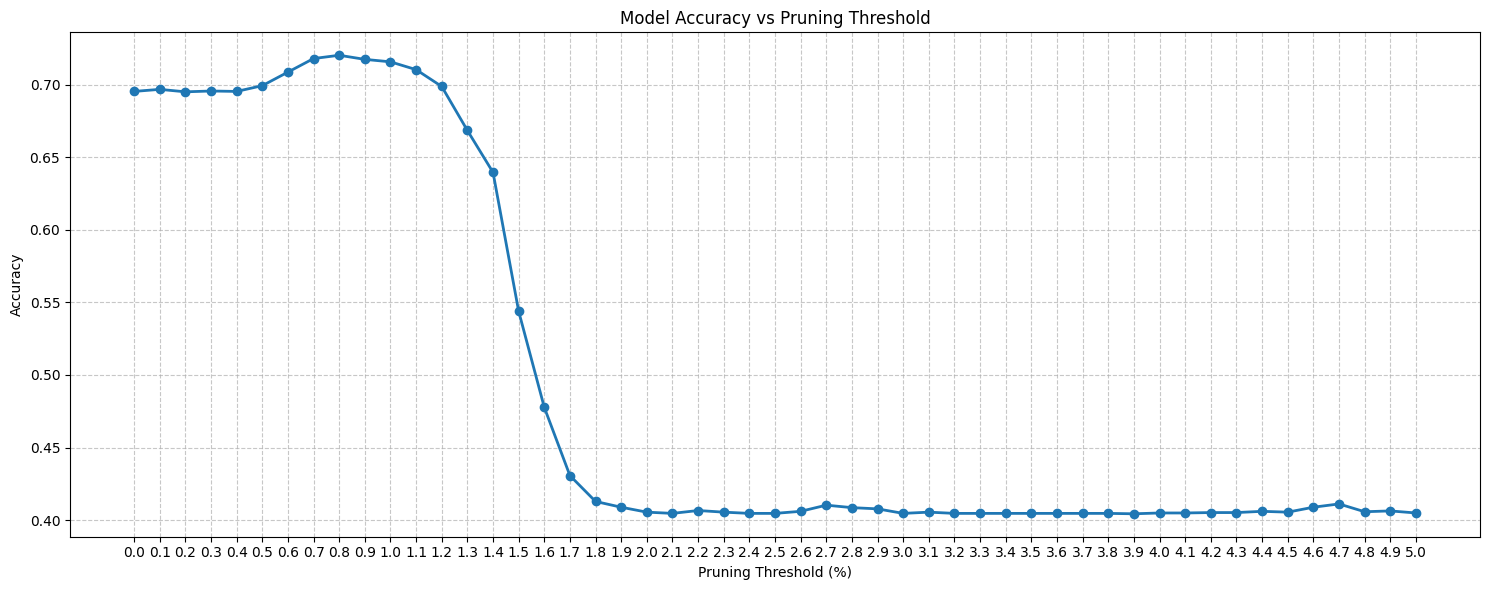

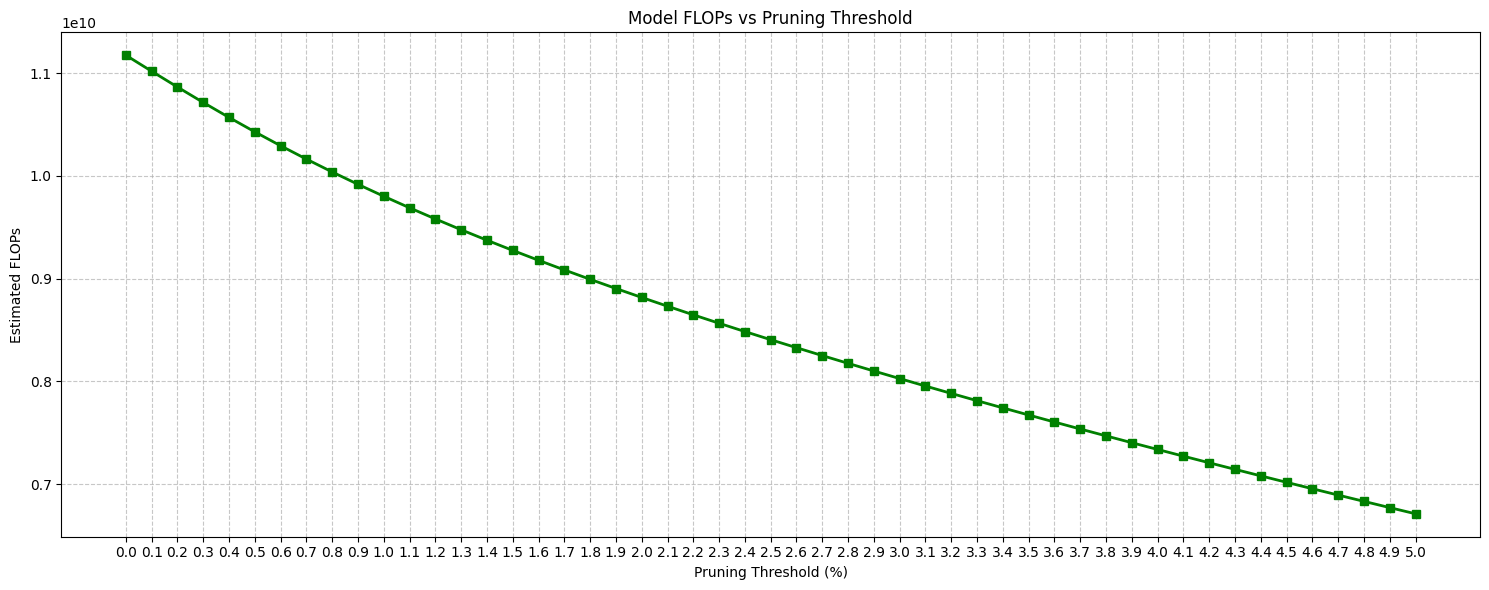

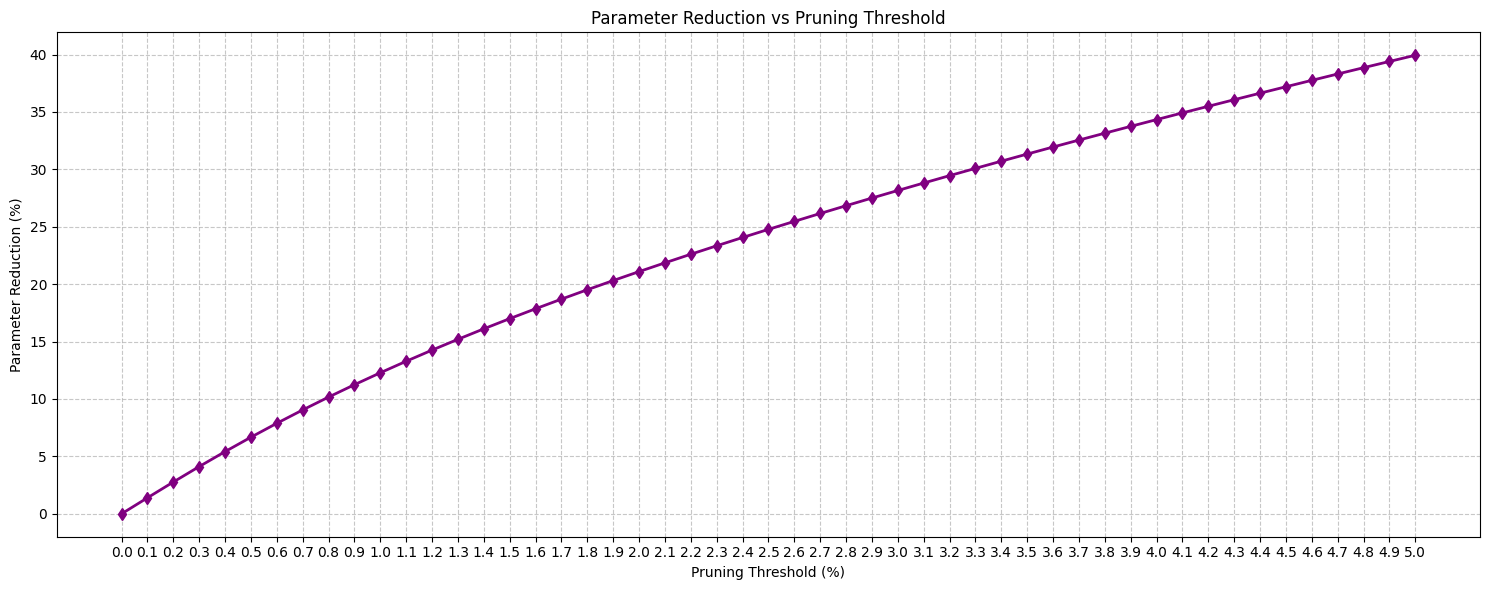

In [8]:
plot_results(results, save_path="pruning_threshold_charts.png")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)

model_org = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
model, metrics = disable_low_weight_neurons(model_org, threshold_percentage=10)

Original metrics:
Number of layers: 192
Parameters: 57,511,628/124,647,939 (46.14%)
Estimated FLOPs: 5,155,427,509

After pruning (threshold: 10%):
Parameters: 20,629,101/124,647,939 (16.55%)
Estimated FLOPs: 1,849,223,165
Reduction in parameters: 64.13%
Reduction in FLOPs: 64.13%


In [52]:
validation_df = pd.read_csv('datasets/sentiment/kaggle/cleaned_test.csv')

label2id = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

predictions = []
true_labels = []
for index, row in validation_df.iterrows():
    text = row['text']
    true_label = row['label']
    
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    predicted_class = np.argmax(scores)
    predictions.append(predicted_class)
    true_labels.append(true_label)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

In [53]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3121
